# GlandsFinder #

### Imports and basic function implempentation ###

In [45]:
from PIL import Image
from PIL import ImageFile
from PIL import Image
import PIL
PIL.Image.MAX_IMAGE_PIXELS = None
from ultralytics import YOLO
import shutil
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
import numpy as np

In [ ]:
def display_files(path, filenames, dpi=450):
    files = [os.path.join(path, f) for f in filenames if os.path.exists(os.path.join(path, f))]
    n = len(files)
    if n == 0:
        print("No files to display.")
        return

    cols = math.ceil(math.sqrt(n))
    rows = math.ceil(n / cols)
    
    fig = plt.figure(figsize=(cols * 5, rows * 4), dpi=dpi)

    for i, file in enumerate(files):
        ax = fig.add_subplot(rows, cols, i + 1)
        img = mpimg.imread(file)
        ax.imshow(img, interpolation='none') 
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_and_resize(results_item, resize_factor):
    img_with_boxes = results_item.plot()
    if img_with_boxes.shape[2] == 3:
        img_with_boxes_rgb = img_with_boxes[..., ::-1]
    img_pil = Image.fromarray(img_with_boxes_rgb)
    width, height = img_pil.size
    new_size = (width // resize_factor, height // resize_factor)
    img_resized = img_pil.resize(new_size, Image.LANCZOS)
    display(img_resized)
    return img_resized

# Basic model training with Clear Data (RGB) #

In [77]:
run_name = "Glands_Finder_Clear_Data"
base_path = f"runs/train/{run_name}"

In [75]:
model = YOLO("yolo11n.pt")

model.train(
    data='../preprocessedData/LearnSet/data.yaml',
    epochs=50,
    imgsz=640,
    project="runs/train",
    name=run_name,
    exist_ok=True
)

New https://pypi.org/project/ultralytics/8.3.111 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.103  Python-3.12.4 torch-2.6.0+cpu CPU (12th Gen Intel Core(TM) i7-12700H)
engine\trainer: task=detect, mode=train, model=yolo11n.pt, data=../preprocessedData/LearnSet/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=runs/train, name=Glands_Finder_Clear_Data, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_mask

train: Scanning C:\Users\stszy\jupyterNoteBookNotes\cellDetector\preprocessedData\LearnSet\data\labels\train.cache... 1


KeyboardInterrupt: 

In [5]:
source_path = f"runs/train/{run_name}/weights/best.pt"
destination_path = f"saved_models/{run_name}_best.pt"
os.makedirs("saved_models", exist_ok=True)
shutil.copy(source_path, destination_path)

'saved_models/Glands_Finder_Clear_Data_best.pt'

In [93]:
model = YOLO("saved_models/Glands_Finder_Clear_Data_best.pt")

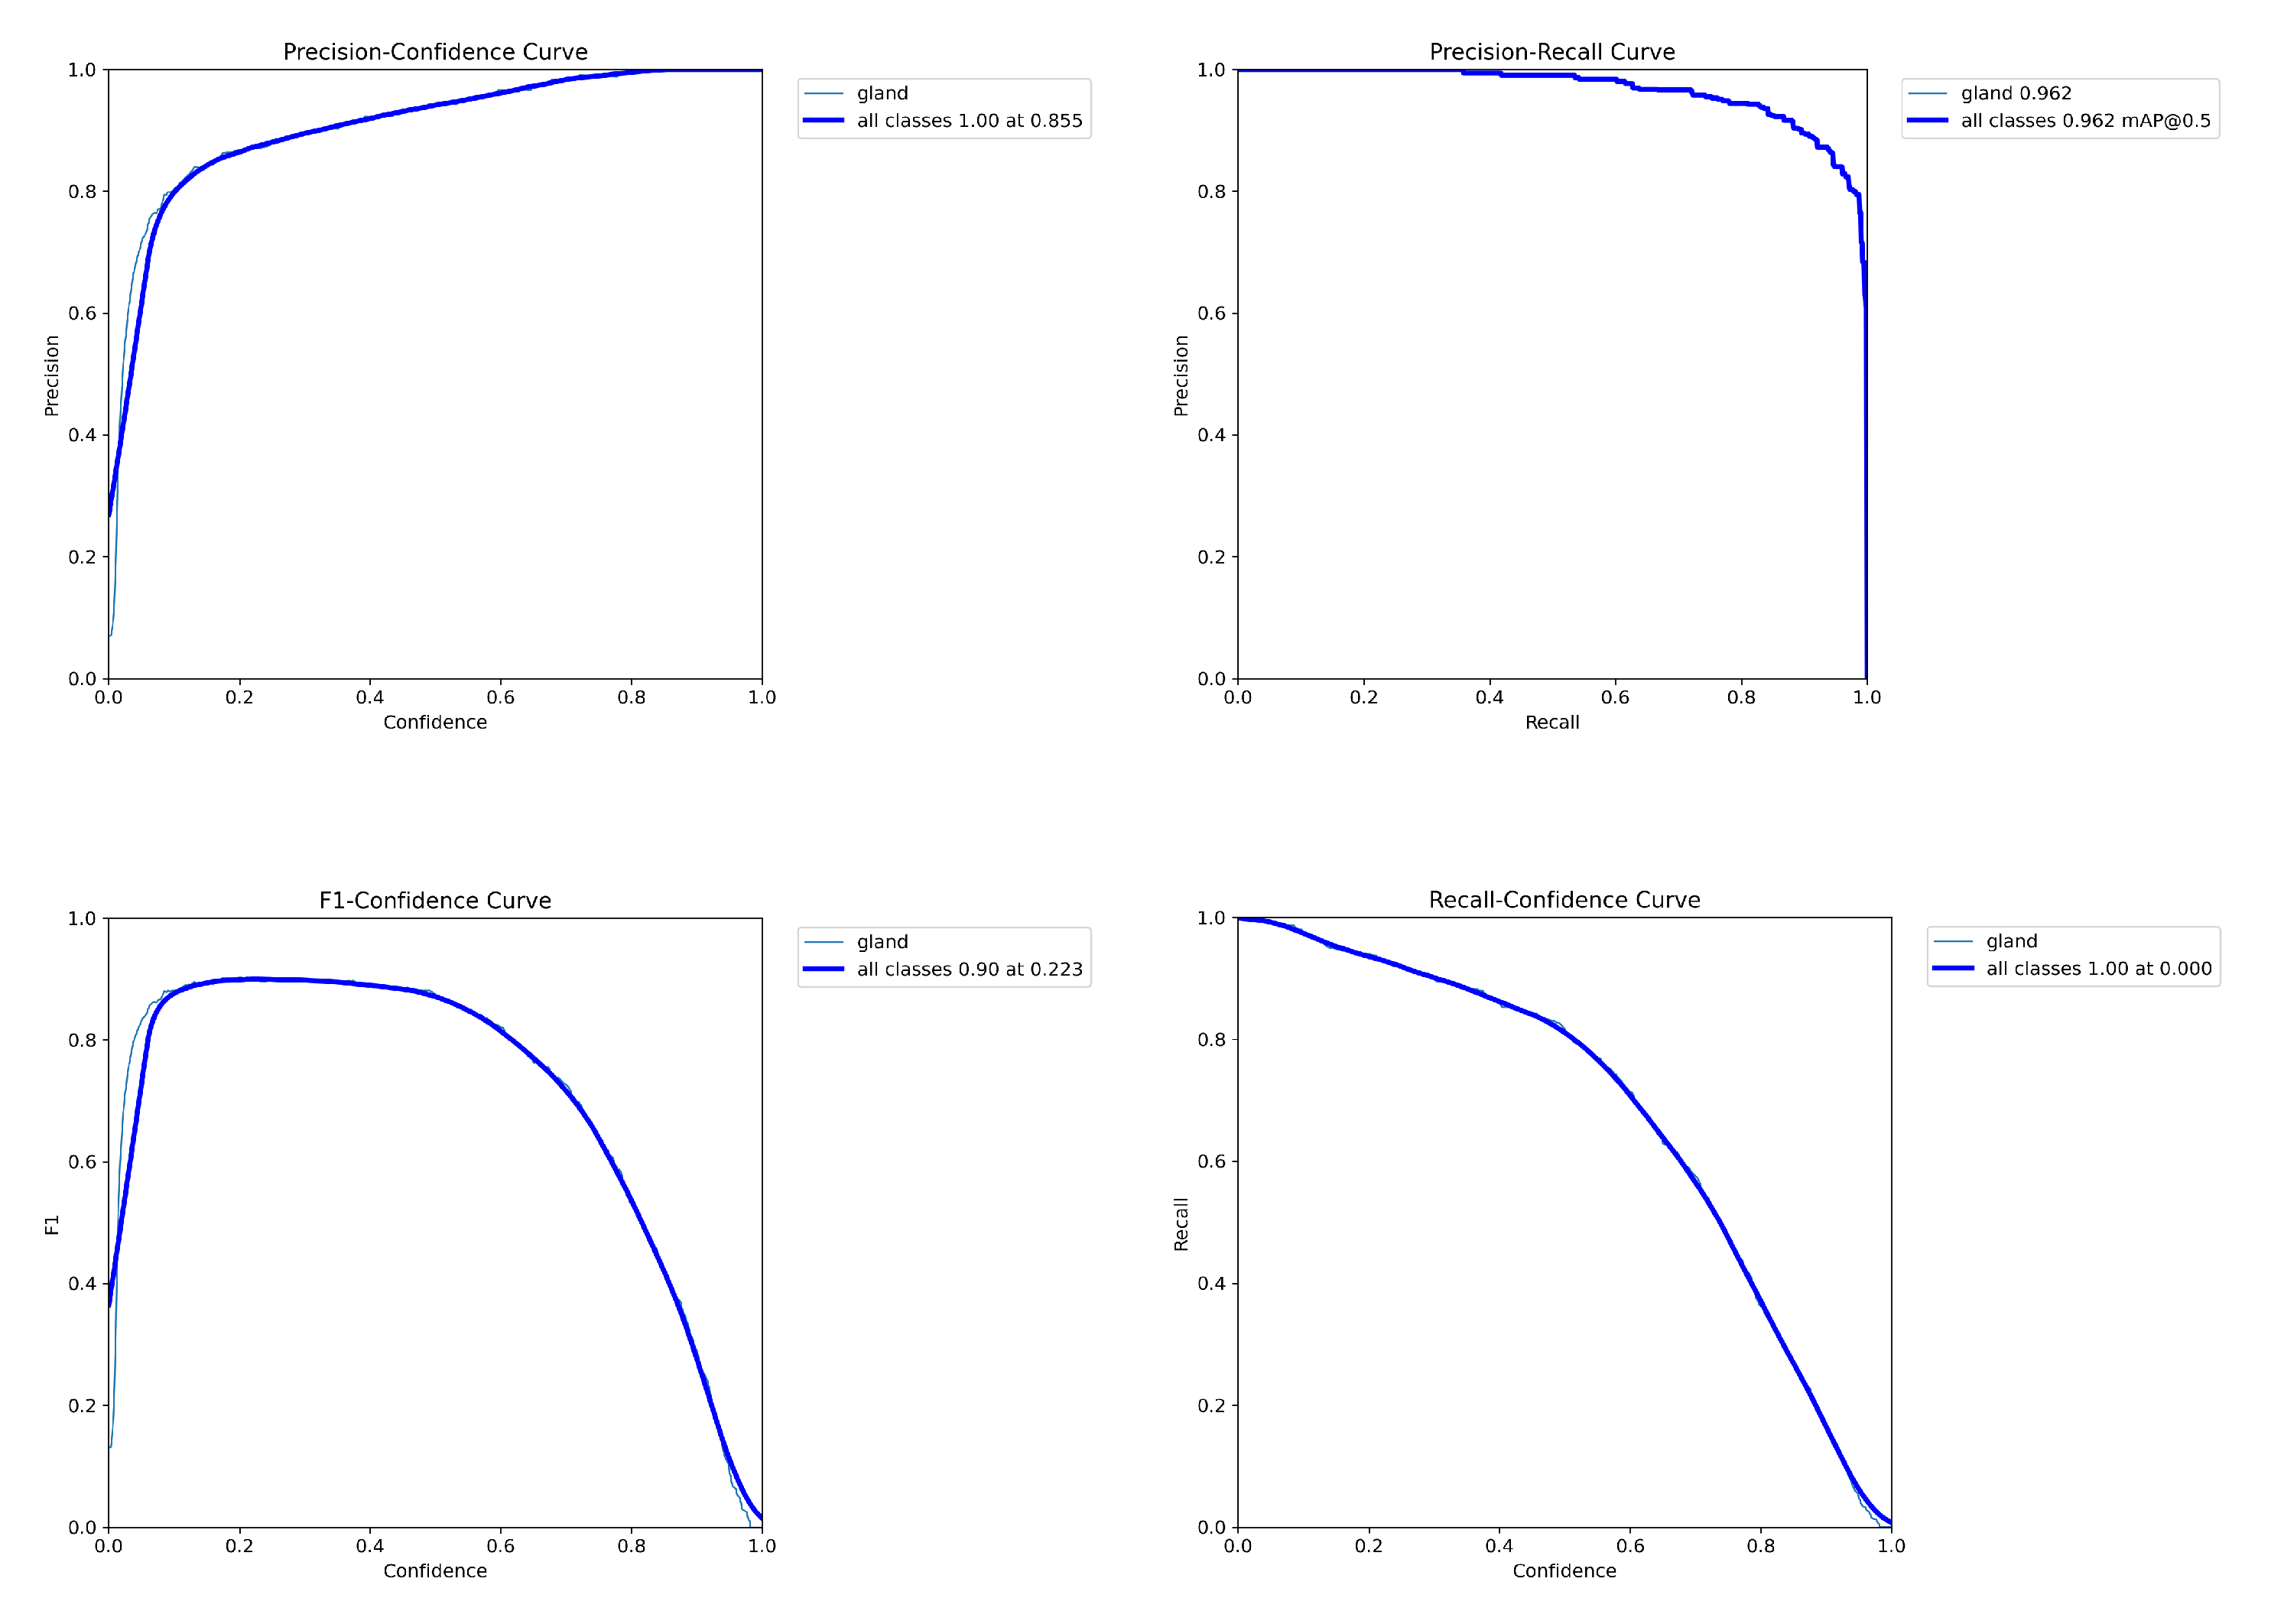

In [79]:
display_files(base_path,['P_curve.png', 'PR_curve.png', 'F1_curve.png', 'R_curve.png'])

In [95]:
display_files(base_path,['confusion_matrix.png' ,'confusion_matrix_normalized.png'])
#display_files(base_path,['confusion_matrix_normalized.png'])

SyntaxError: invalid syntax (687370927.py, line 1)

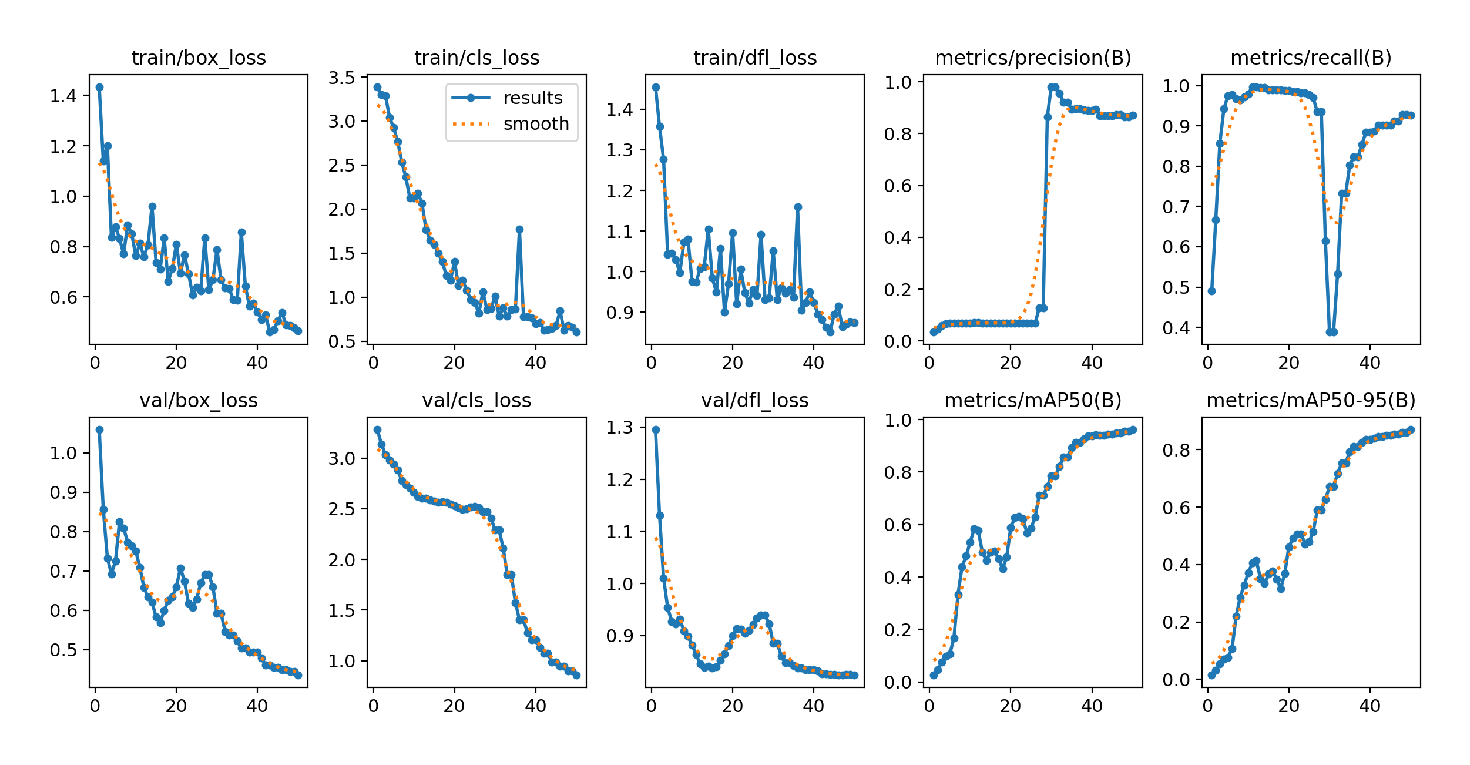

In [96]:
display_files(base_path,['results.png'])

In [81]:
img = Image.open("../preprocessedData/patient0.tif")
results = model(img, conf=0.05)


0: 640x640 79 glands, 76.3ms
Speed: 4.4ms preprocess, 76.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


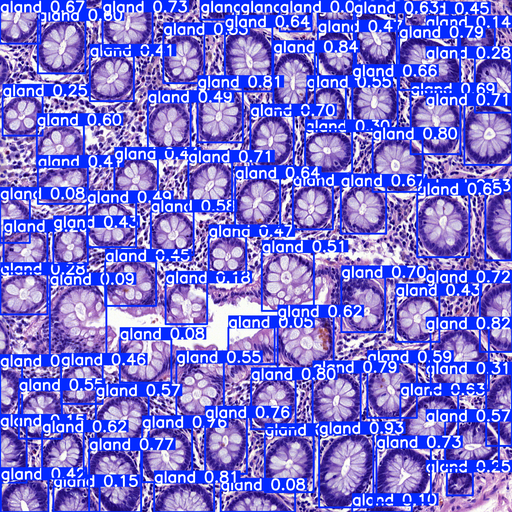

In [82]:
resized_img = plot_and_resize(results[0], 4)

# RestNet101 model training with Clear Data #

# Augumentation #

In [21]:
import os
import cv2
import albumentations as A

In [ ]:
def load_labels(label_path):
    bboxes = []
    class_labels = []
    with open(label_path, 'r') as f:
        for line in f.readlines():
            parts = line.strip().split()
            class_id = int(parts[0])
            bbox = list(map(float, parts[1:]))
            bboxes.append(bbox)
            class_labels.append(class_id)
    return bboxes, class_labels

In [ ]:
def save_augmented_data(image, bboxes, class_labels, out_img_path, out_label_path):
    cv2.imwrite(out_img_path, image)
    with open(out_label_path, 'w') as f:
        for cls, bbox in zip(class_labels, bboxes):
            f.write(f"{cls} {' '.join(map(str, bbox))}\n")

In [25]:
transformations = [
    A.Compose([A.Rotate(limit=(0, 0), p=1)], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels'])),
    A.Compose([A.Rotate(limit=(90, 90), p=1)], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels'])),
    A.Compose([A.Rotate(limit=(180, 180), p=1)], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels'])),
    A.Compose([A.Rotate(limit=(270, 270), p=1)], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels'])),
]

flip = A.Compose([
    A.HorizontalFlip(p=1)
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

images_dir = '../preprocessedData/LearnSet/data/images/train'
labels_dir =  '../preprocessedData/LearnSet/data/labels/train'
output_images_dir = '../preprocessedData/LearnSet/dataAugumented/images/train'
output_labels_dir = '../preprocessedData/LearnSet/dataAugumented/labels/train'

os.makedirs(images_dir, exist_ok=True)
os.makedirs(labels_dir, exist_ok=True)
os.makedirs(output_images_dir, exist_ok=True)
os.makedirs(output_labels_dir, exist_ok=True)

for filename in os.listdir(images_dir):
    if not filename.lower().endswith(('.jpg', '.png', '.jpeg', '.tif', '.tiff')):
        continue

    img_path = os.path.join(images_dir, filename)
    label_path = os.path.join(labels_dir, filename.rsplit('.', 1)[0] + '.txt')

    image = cv2.imread(img_path)
    if image is None:
        print(f"Cannot read image: {img_path}")
        continue

    bboxes, class_labels = load_labels(label_path)
    if not bboxes:
        continue

    for i, rot in enumerate(transformations):
        result = rot(image=image, bboxes=bboxes, class_labels=class_labels)
        out_name = f"{filename.rsplit('.', 1)[0]}_rot{i}"
        save_augmented_data(
            result['image'],
            result['bboxes'],
            result['class_labels'],
            os.path.join(output_images_dir, out_name + '.tif'),
            os.path.join(output_labels_dir, out_name + '.txt')
        )

        flipped = flip(image=result['image'], bboxes=result['bboxes'], class_labels=result['class_labels'])
        out_name_flip = f"{filename.rsplit('.', 1)[0]}_rot{i}_flip"
        save_augmented_data(
            flipped['image'],
            flipped['bboxes'],
            flipped['class_labels'],
            os.path.join(output_images_dir, out_name_flip + '.tif'),
            os.path.join(output_labels_dir, out_name_flip + '.txt')
        )


# Model trainig with augumented Data #

In [98]:
run_name = "Glands_Finder_Augumented_Data"
base_path = f"runs/train/{run_name}"

In [16]:
model = YOLO("yolo11n.pt")
model.train(
    data='../preprocessedData/LearnSet/dataAugumented.yaml',
    epochs=50,
    imgsz=640,
    project="runs/train",
    name=run_name,
    exist_ok=True
)

New https://pypi.org/project/ultralytics/8.3.111 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.103  Python-3.12.4 torch-2.6.0+cpu CPU (12th Gen Intel Core(TM) i7-12700H)
engine\trainer: task=detect, mode=train, model=yolo11n.pt, data=../preprocessedData/LearnSet/dataAugumented.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=runs/train, name=Glands_Finder_Augumented_Data, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=No

train: Scanning C:\Users\stszy\jupyterNoteBookNotes\cellDetector\preprocessedData\LearnSet\dataAugumented\labels\train.

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning C:\Users\stszy\jupyterNoteBookNotes\cellDetector\preprocessedData\LearnSet\dataAugumented\labels\train.ca

Plotting labels to runs\train\Glands_Finder_Augumented_Data\labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\train\Glands_Finder_Augumented_Data
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50         0G      1.061      3.147      1.224        319        640: 100%|██████████| 10/10 [00:43<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:20<0

                   all        152       3200     0.0689      0.982      0.159       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50         0G     0.7686       2.29     0.9754        272        640: 100%|██████████| 10/10 [00:35<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:20<0

                   all        152       3200     0.0697      0.993        0.6       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50         0G     0.7811       1.59      0.986        200        640: 100%|██████████| 10/10 [00:33<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:21<0

                   all        152       3200     0.0698      0.994      0.414      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50         0G     0.7406      1.165     0.9552        242        640: 100%|██████████| 10/10 [00:35<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:22<0

                   all        152       3200     0.0683      0.973      0.603      0.464

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       5/50         0G     0.6975     0.8717     0.9594        197        640: 100%|██████████| 10/10 [00:34<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:21<0

                   all        152       3200     0.0639      0.911      0.399      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50         0G     0.6935     0.8148     0.9492        152        640: 100%|██████████| 10/10 [00:34<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:23<0

                   all        152       3200      0.949      0.769      0.915       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50         0G     0.6481     0.7615     0.9415        211        640: 100%|██████████| 10/10 [00:35<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:24<0

                   all        152       3200       0.91      0.889      0.946      0.792

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       8/50         0G     0.6211     0.7305     0.9338        310        640: 100%|██████████| 10/10 [00:34<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:25<0

                   all        152       3200      0.832      0.843      0.904      0.766

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       9/50         0G      0.608     0.7004     0.9225        147        640: 100%|██████████| 10/10 [00:35<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:24<0

                   all        152       3200      0.922      0.922      0.969      0.852



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50         0G     0.5977     0.6454     0.9094        246        640: 100%|██████████| 10/10 [00:36<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:23<0

                   all        152       3200      0.924        0.9      0.967      0.857



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50         0G     0.5877     0.6511     0.9178        255        640: 100%|██████████| 10/10 [00:34<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:24<0

                   all        152       3200      0.929      0.909      0.971      0.863

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      12/50         0G     0.5596     0.6174     0.9017        270        640: 100%|██████████| 10/10 [00:35<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:23<0

                   all        152       3200      0.943       0.93      0.979      0.883

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      13/50         0G     0.5535     0.6313     0.8971        317        640: 100%|██████████| 10/10 [00:34<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:22<0

                   all        152       3200      0.922      0.955      0.978      0.867



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50         0G     0.5714     0.5972      0.903        278        640: 100%|██████████| 10/10 [00:33<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:23<0

                   all        152       3200      0.936      0.968      0.981      0.883

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      15/50         0G     0.5571     0.5847     0.8954        265        640: 100%|██████████| 10/10 [00:36<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:22<0

                   all        152       3200      0.935      0.952      0.976      0.876

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      16/50         0G     0.5487      0.583     0.8978        255        640: 100%|██████████| 10/10 [00:35<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:22<0

                   all        152       3200      0.942      0.967      0.986      0.876



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50         0G     0.5616     0.5746     0.8939        224        640: 100%|██████████| 10/10 [00:36<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:21<0

                   all        152       3200      0.951      0.966      0.988      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50         0G     0.5573     0.5842     0.8983        346        640: 100%|██████████| 10/10 [00:35<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:22<0

                   all        152       3200      0.917      0.959      0.972      0.877

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      19/50         0G     0.5446     0.5737     0.8953        195        640: 100%|██████████| 10/10 [00:35<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:22<0

                   all        152       3200       0.94      0.971      0.984      0.894

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      20/50         0G     0.5239     0.5415     0.8885        242        640: 100%|██████████| 10/10 [00:36<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:24<0

                   all        152       3200      0.955      0.973      0.989      0.903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50         0G     0.5368     0.5345     0.8919        236        640: 100%|██████████| 10/10 [00:37<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:22<0

                   all        152       3200      0.955      0.976      0.989      0.906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50         0G     0.5308     0.5385     0.8941        178        640: 100%|██████████| 10/10 [00:34<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:22<0

                   all        152       3200      0.955      0.963      0.986       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50         0G     0.5173     0.5203     0.8874        299        640: 100%|██████████| 10/10 [00:33<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:21<0

                   all        152       3200      0.951      0.966      0.986      0.902

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      24/50         0G     0.5321     0.5421     0.9035        165        640: 100%|██████████| 10/10 [00:33<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:22<0

                   all        152       3200      0.977      0.976      0.992      0.909

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      25/50         0G     0.5138     0.5526     0.8886        273        640: 100%|██████████| 10/10 [00:33<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:23<0

                   all        152       3200      0.977      0.976      0.993      0.924

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      26/50         0G     0.4767     0.5031     0.8737        302        640: 100%|██████████| 10/10 [00:34<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:23<0

                   all        152       3200      0.961      0.973      0.986      0.918



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50         0G     0.5125     0.5063     0.8834        173        640: 100%|██████████| 10/10 [00:34<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:23<0

                   all        152       3200      0.962      0.973      0.987      0.911

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      28/50         0G     0.4942      0.482     0.8808        290        640: 100%|██████████| 10/10 [00:34<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:23<0

                   all        152       3200      0.969      0.981      0.991      0.922



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50         0G     0.4788     0.4742     0.8703        242        640: 100%|██████████| 10/10 [00:36<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:23<0

                   all        152       3200      0.974      0.978      0.991      0.918

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      30/50         0G     0.4868     0.4832     0.8689        224        640: 100%|██████████| 10/10 [00:33<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:23<0

                   all        152       3200      0.973      0.983      0.993      0.928

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      31/50         0G     0.4633     0.4599     0.8641        197        640: 100%|██████████| 10/10 [00:35<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:22<0

                   all        152       3200      0.978      0.981      0.993      0.927

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      32/50         0G     0.4827     0.4665     0.8768        179        640: 100%|██████████| 10/10 [00:33<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:23<0

                   all        152       3200      0.987      0.988      0.994      0.935

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      33/50         0G     0.4791     0.4707     0.8703        341        640: 100%|██████████| 10/10 [00:34<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:23<0

                   all        152       3200      0.991      0.992      0.994      0.933

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      34/50         0G     0.4492     0.4437     0.8599        271        640: 100%|██████████| 10/10 [00:34<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:23<0

                   all        152       3200      0.989      0.989      0.994      0.931



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50         0G      0.476     0.4571      0.868        276        640: 100%|██████████| 10/10 [00:34<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:23<0

                   all        152       3200      0.982       0.99      0.993      0.929



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50         0G     0.4597      0.447     0.8675        284        640: 100%|██████████| 10/10 [00:34<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:23<0

                   all        152       3200       0.99      0.994      0.994      0.933



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50         0G     0.4585     0.4327     0.8668        295        640: 100%|██████████| 10/10 [00:33<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:23<0

                   all        152       3200      0.989      0.994      0.995       0.94

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      38/50         0G     0.4569     0.4425     0.8662        210        640: 100%|██████████| 10/10 [00:34<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:23<0

                   all        152       3200      0.985      0.994      0.994      0.941

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      39/50         0G     0.4531     0.4437     0.8642        120        640: 100%|██████████| 10/10 [00:34<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:24<0

                   all        152       3200      0.985      0.996      0.994      0.941



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50         0G     0.4424     0.4139     0.8592        253        640: 100%|██████████| 10/10 [00:35<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:23<0

                   all        152       3200      0.987      0.996      0.994      0.933
Closing dataloader mosaic


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50         0G      0.409     0.4412     0.8384        225        640: 100%|██████████| 10/10 [00:32<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:25<0

                   all        152       3200      0.984      0.993      0.994      0.942



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50         0G     0.4026     0.4166     0.8374        195        640: 100%|██████████| 10/10 [00:36<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:24<0

                   all        152       3200      0.968      0.992      0.993      0.942

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      43/50         0G     0.3777     0.4092     0.8266        185        640: 100%|██████████| 10/10 [00:32<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:23<0

                   all        152       3200      0.976      0.994      0.994      0.939

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      44/50         0G     0.3834      0.405     0.8283        122        640: 100%|██████████| 10/10 [00:32<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:23<0

                   all        152       3200      0.983      0.994      0.993      0.946



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50         0G     0.3761     0.3911     0.8219        152        640: 100%|██████████| 10/10 [00:34<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:23<0

                   all        152       3200      0.985      0.992      0.993      0.946

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      46/50         0G     0.3864     0.4008     0.8247        227        640: 100%|██████████| 10/10 [00:32<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:21<0

                   all        152       3200      0.985      0.994      0.994      0.947



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50         0G     0.3777     0.3861     0.8283        130        640: 100%|██████████| 10/10 [00:32<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:21<0

                   all        152       3200      0.989      0.996      0.994       0.95

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      48/50         0G      0.375     0.3798     0.8264        202        640: 100%|██████████| 10/10 [00:31<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:23<0

                   all        152       3200      0.996      0.998      0.995      0.952

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      49/50         0G     0.3673     0.3749     0.8228        161        640: 100%|██████████| 10/10 [00:32<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:22<0

                   all        152       3200      0.996      0.998      0.995      0.953

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      50/50         0G     0.3695     0.3868     0.8336        146        640: 100%|██████████| 10/10 [00:33<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:21<0

                   all        152       3200      0.996      0.999      0.995      0.954

50 epochs completed in 0.808 hours.


Optimizer stripped from runs\train\Glands_Finder_Augumented_Data\weights\last.pt, 5.5MB
Optimizer stripped from runs\train\Glands_Finder_Augumented_Data\weights\best.pt, 5.5MB

Validating runs\train\Glands_Finder_Augumented_Data\weights\best.pt...
Ultralytics 8.3.103  Python-3.12.4 torch-2.6.0+cpu CPU (12th Gen Intel Core(TM) i7-12700H)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:20<0


                   all        152       3200      0.996      0.998      0.995      0.954
Speed: 1.0ms preprocess, 63.2ms inference, 0.0ms loss, 6.5ms postprocess per image
Results saved to runs\train\Glands_Finder_Augumented_Data


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000021EDB934140>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0480

In [17]:
source_path = f"runs/train/{run_name}/weights/best.pt"
destination_path = f"saved_models/{run_name}_best.pt"

os.makedirs("saved_models", exist_ok=True)
shutil.copy(source_path, destination_path)

'saved_models/Glands_Finder_Augumented_Data_best.pt'

In [99]:
model = YOLO("saved_models/Glands_Finder_Augumented_Data_best.pt")

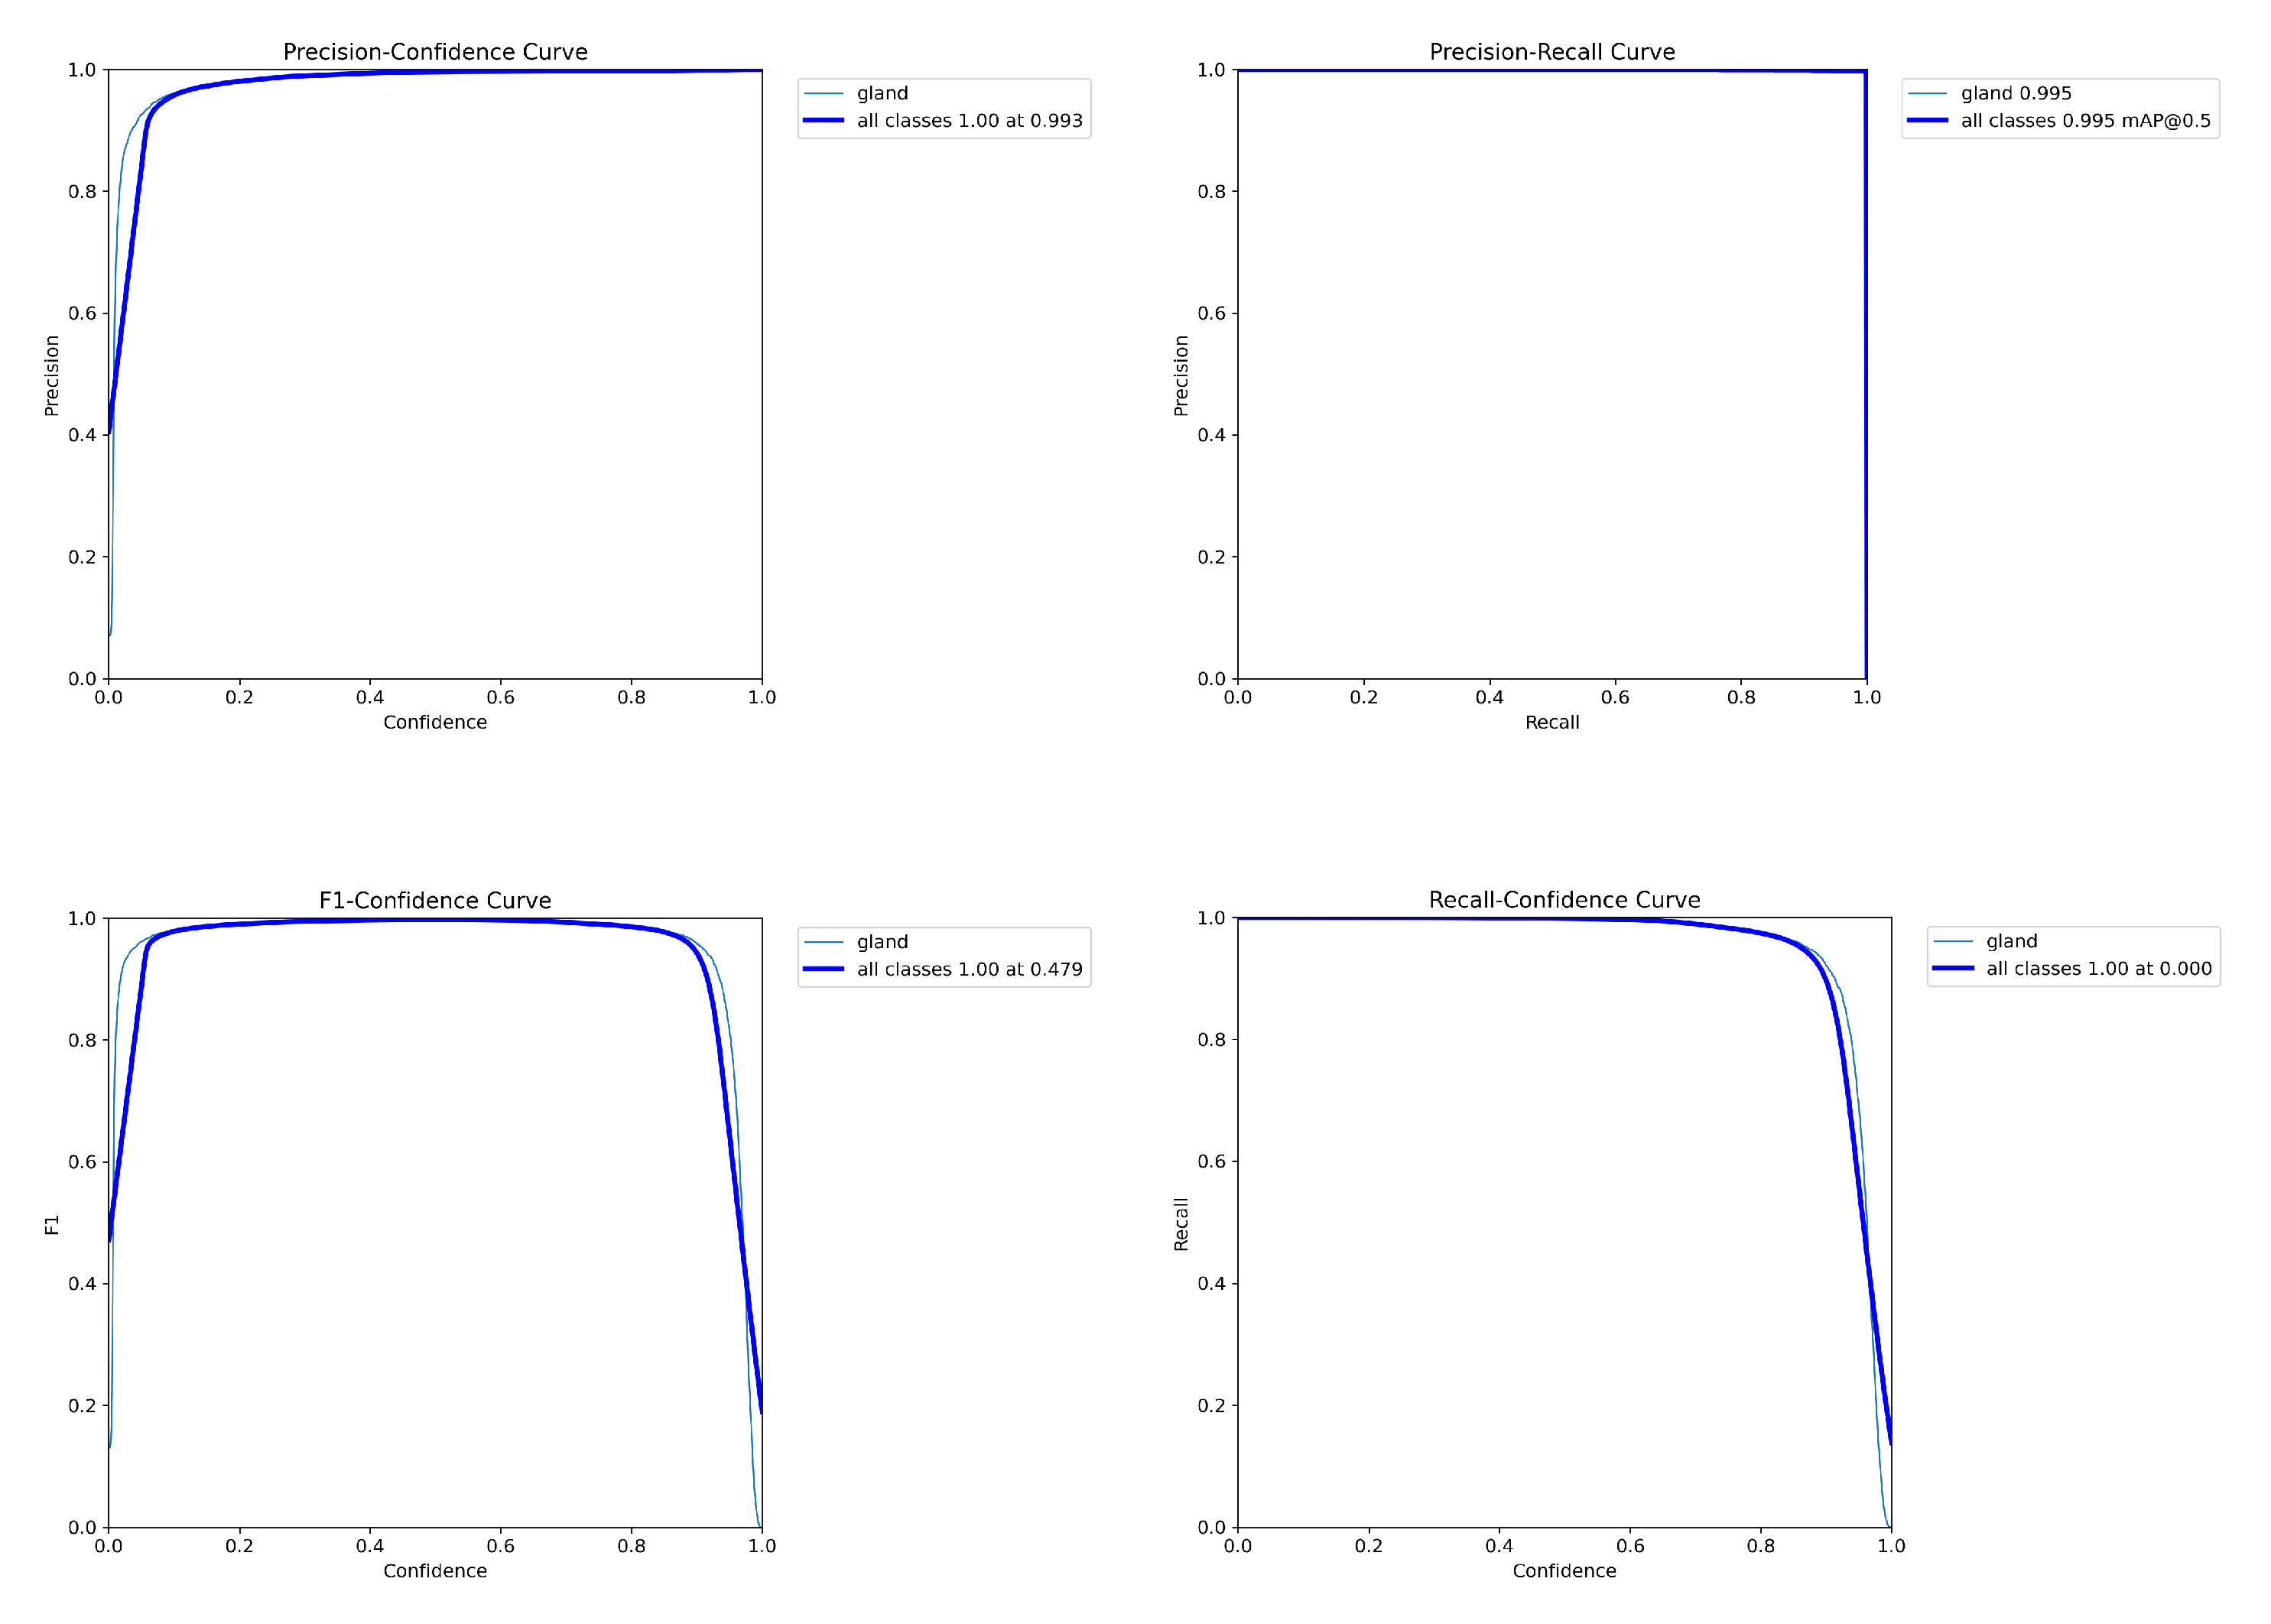

In [100]:
display_files(base_path,['P_curve.png', 'PR_curve.png', 'F1_curve.png', 'R_curve.png'])

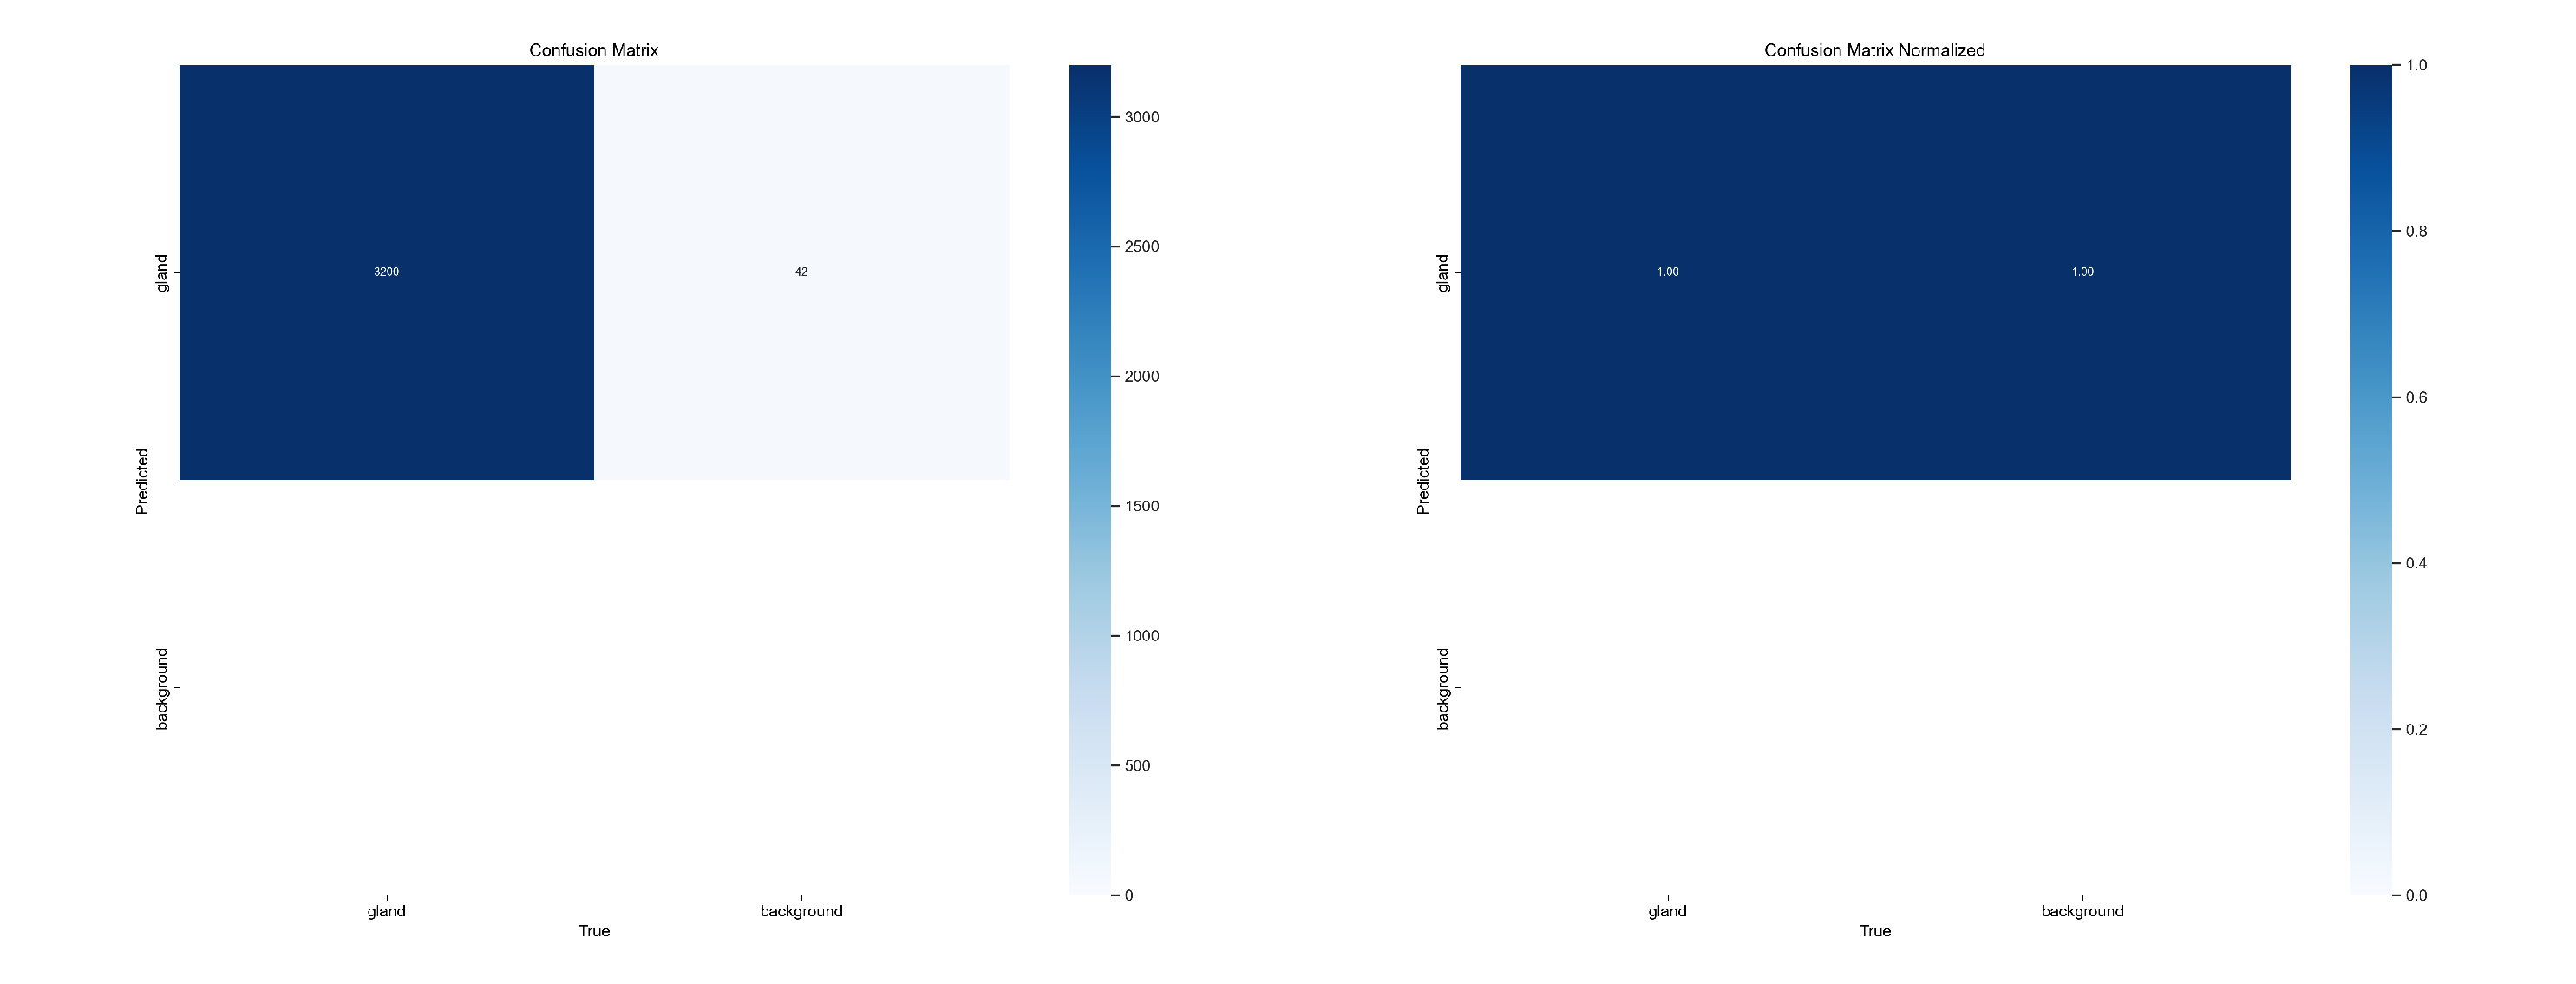

In [101]:
display_files(base_path,['confusion_matrix.png' ,'confusion_matrix_normalized.png'])
#display_files(base_path,['confusion_matrix_normalized.png'])

In [ ]:
display_files(base_path,['results.png'])

In [102]:
img = Image.open("../preprocessedData/patient0.tif")
results = model(img, conf=0.05)


0: 640x640 82 glands, 80.1ms
Speed: 4.4ms preprocess, 80.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


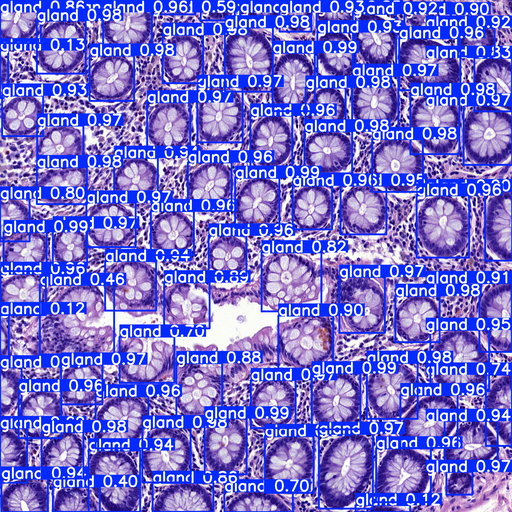

In [103]:
resized_img = plot_and_resize(results[0], 4)